# Activations

## A simple baseline

In [ ]:
from datasets import load_dataset
from matplotlib import pyplot as plt
from functools import partial
import random
import fastcore.all as fc
import numpy as np
import torch
from torch import nn, tensor
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from minai.datasets import inplace, show_image, subplots, get_grid
from minai.learner import DataLoaders, TrainLearner, DeviceCB, MetricsCB, ProgressCB, Callback
from torcheval.metrics import MulticlassAccuracy

/Users/anubhavmaity/mambaforge/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.27) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [ ]:
def set_seed(num):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(num)
    np.random.seed(num)
    random.seed(num)

In [ ]:
set_seed(1)

In [ ]:
x, y = 'image', 'label'
ds = load_dataset('fashion_mnist'); ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
ds['train'][x][0]

In [ ]:
ds['train'].features[y].names[ds['train'][y][0]]

'Ankle boot'

In [ ]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
bs = 1024
ds = ds.with_transform(transformi)

In [ ]:
dls = DataLoaders.from_dd(ds, batch_size=bs)

In [ ]:
xb, yb = next(iter(dls.train))

In [ ]:
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
def get_cnn():
    return [
        conv(1, 8, ks=5), # 14 x 14
        conv(8, 16), # 7 x 7
        conv(16, 32), # 4 x 4
        conv(32, 64), # 2 x 2
        conv(64, 10), # 1 x 1
        nn.Flatten()
    ]

In [ ]:
model = nn.Sequential(*get_cnn()); model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
metrics = MetricsCB(accuracy = MulticlassAccuracy())

In [ ]:
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [ ]:
def fit(model, epochs=1, xtra_cbs=[]):
    learn = TrainLearner(model, dls, F.cross_entropy, lr = 0.2, cbs = cbs + xtra_cbs)
    learn.fit(epochs)
    return learn

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

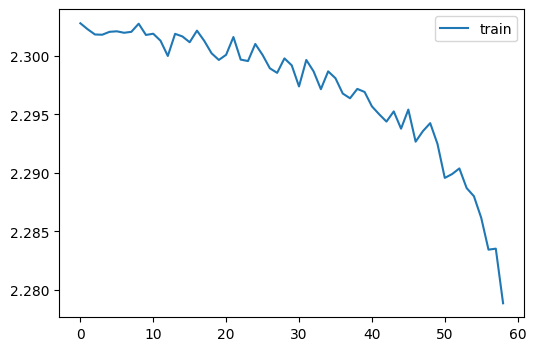

In [ ]:
learn = fit(model)

## Activations

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.acts_mean = [[] for _ in self.layers]
        self.acts_std = [[] for _ in self.layers]
    
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.acts_mean[i].append(x.mean().item())
            self.acts_std[i].append(x.std().item())
        return x        

In [ ]:
set_seed(1)
model = SequentialModel(get_cnn())

In [ ]:
model(xb).shape

torch.Size([1024, 10])

In [ ]:
model.acts_mean

[[0.1183953583240509],
 [0.07508992403745651],
 [0.025566529482603073],
 [0.021553577855229378],
 [0.01478145457804203],
 [0.01478145457804203]]

In [ ]:
model.acts_std

[[0.19685578346252441],
 [0.09300746023654938],
 [0.0430472232401371],
 [0.02565145120024681],
 [0.01696172170341015],
 [0.01696172170341015]]

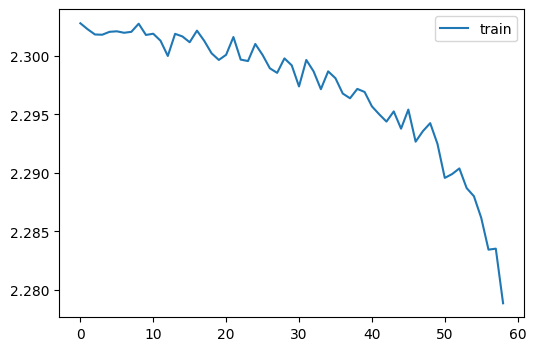

<minai.learner.TrainLearner>

In [ ]:
set_seed(1)
model = SequentialModel(get_cnn())
fit(model)

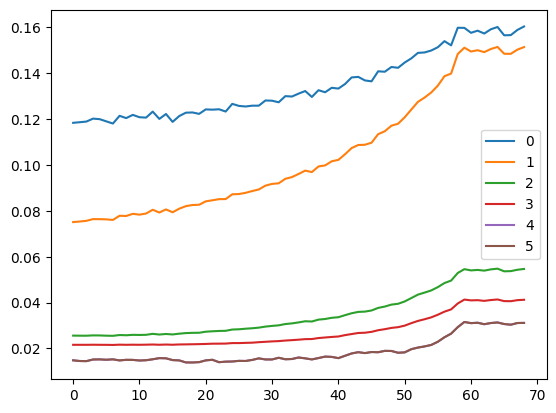

In [ ]:
for i, l in enumerate(model.layers):
    plt.plot(model.acts_mean[i])
plt.legend(range(6));

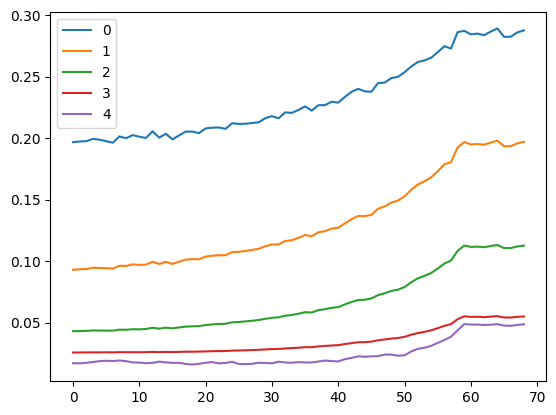

In [ ]:
for i, l in enumerate(model.layers[:5]):
    plt.plot(model.acts_std[i])
plt.legend(range(6));

## PyTorch Hooks

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

In [ ]:
acts_mean = [[] for layer in model]
acts_std = [[] for layer in model]

In [ ]:
len(acts_mean), len(acts_std)

(6, 6)

In [ ]:
def append_stats(i, module, inp, outp):
    acts_mean[i].append(outp.mean().item())
    acts_std[i].append(outp.std().item())

In [ ]:
for i, layer in enumerate(model): layer.register_forward_hook(partial(append_stats, i))

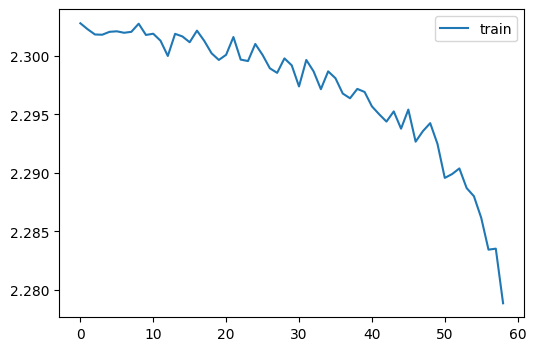

<minai.learner.TrainLearner>

In [ ]:
fit(model)

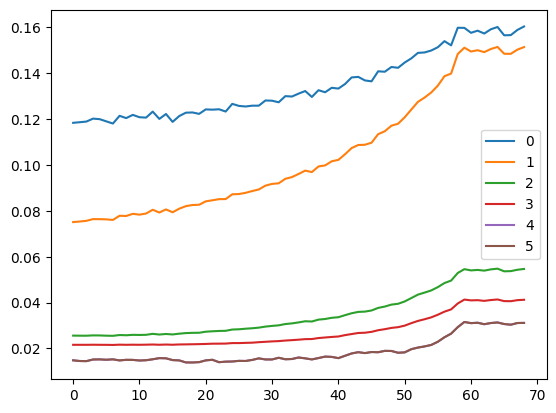

In [ ]:
for i, l in enumerate(model):
    plt.plot(acts_mean[i])
plt.legend(range(6));

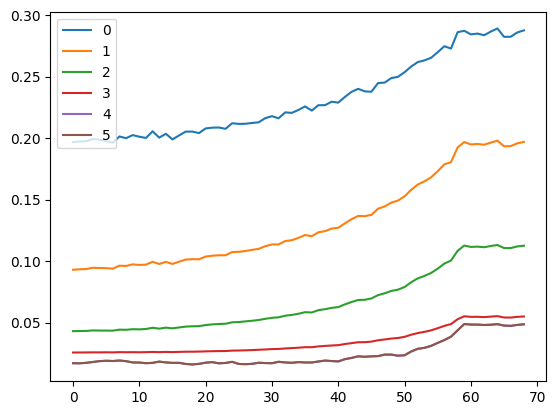

In [ ]:
for i, l in enumerate(model):
    plt.plot(acts_std[i])
plt.legend(range(6));

## Hook

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

In [ ]:
class Hook:
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.hook.remove()

In [ ]:
def append_stats(hook, module, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    hook.stats[0].append(outp.mean().item())
    hook.stats[1].append(outp.std().item())

In [ ]:
hooks = [Hook(l, append_stats) for l in model]

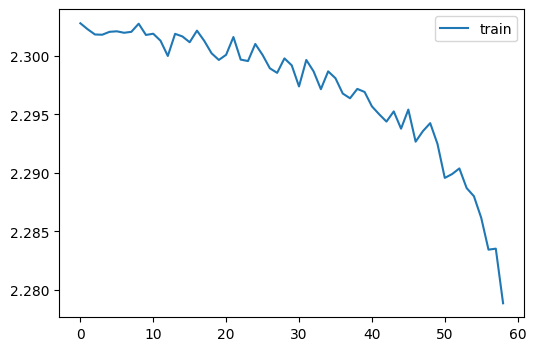

<minai.learner.TrainLearner>

In [ ]:
fit(model)

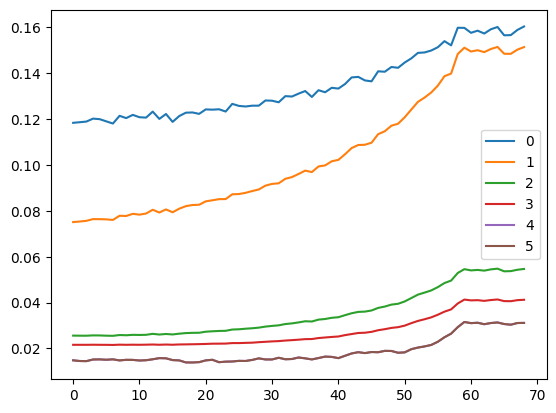

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
plt.legend(range(6));

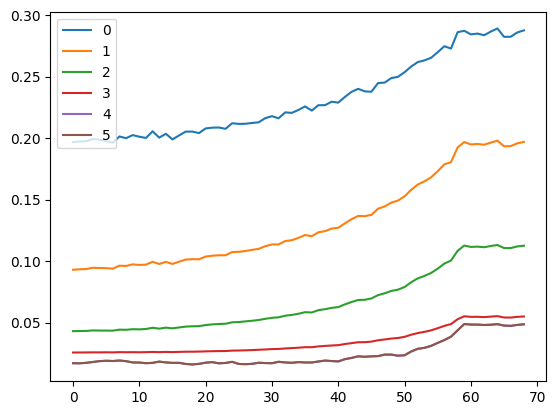

In [ ]:
for h in hooks:
    plt.plot(h.stats[1])
plt.legend(range(6));

In [ ]:
for h in hooks: h.remove()

## Dummy Context Manager

In [ ]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("Entering the context")
        return self
    def __exit__(self, *args):
        print("Exiting the context")
    def hello(self):
        print("hello")

In [ ]:
with DummyCtxMgr() as dcm:
    dcm.hello()

Entering the context
hello
Exiting the context


In [ ]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Removing {i} item")
        super().__delitem__(i)

In [ ]:
l = DummyList([1, 2, 3])

In [ ]:
del(l[2])

Removing 2 item


In [ ]:
l

[1, 2]

## Hooks

In [ ]:
class Hooks(list):
    def __init__(self, model, f): super().__init__([Hook(m, f) for m in model])
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def remove(self):
        for h in self: h.remove()
    
    def __delitem__(self, i):
        self.hooks[i].remove()
        super().__delitem__(i)
        
    def __del__(self):
        self.remove()

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

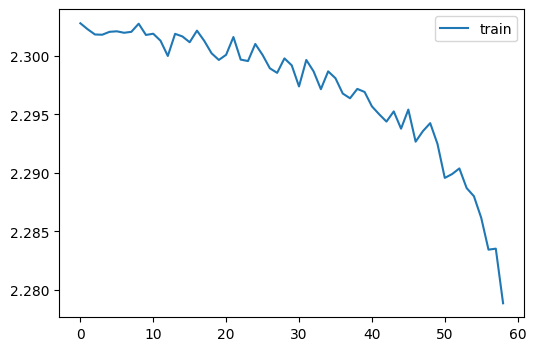

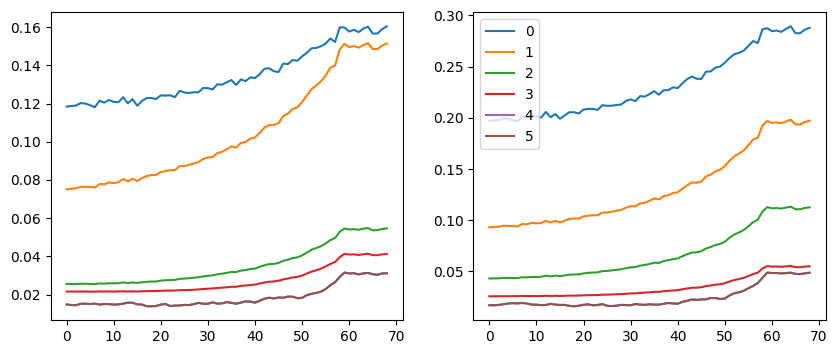

In [ ]:
with Hooks(model, append_stats) as hook:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for h in hook:
        for i in 0, 1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6));

In [ ]:
nn.Sequential(*get_cnn())

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

## Hooks Callback

In [ ]:
class HooksCB(Callback):
    def __init__(self, f, mod_filter=fc.noop):
        fc.store_attr()
        
    def before_fit(self):
        mods = fc.filter_ex(self.learn.model.modules(), f=self.mod_filter)
        self.hooks = Hooks(mods, self._f)
    
    def _f(self, *args, **kwargs):
        if self.training: self.f(*args, **kwargs)
    
    
    def __iter__(self): return iter(self.hooks)
    
    def __len__(self): return len(self.hooks)
    
    def after_fit(self):
        self.hooks.remove()

In [ ]:
hcb = HooksCB(append_stats, mod_filter=fc.risinstance([nn.ReLU, nn.Flatten]))

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

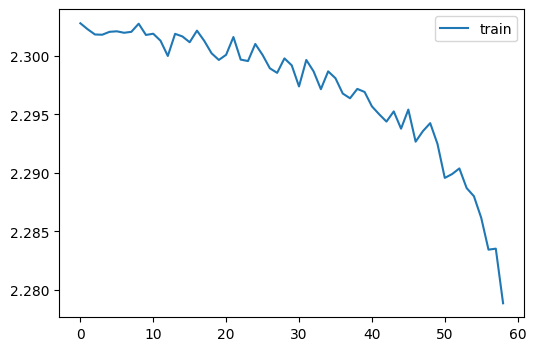

<minai.learner.TrainLearner>

In [ ]:
fit(model, xtra_cbs=[hcb])

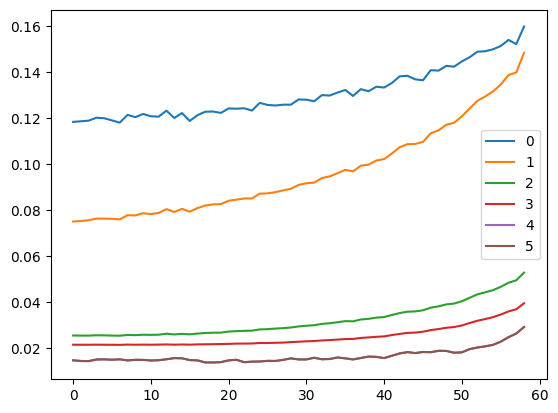

In [ ]:
for h in hcb:
    plt.plot(h.stats[0])
plt.legend(range(6));

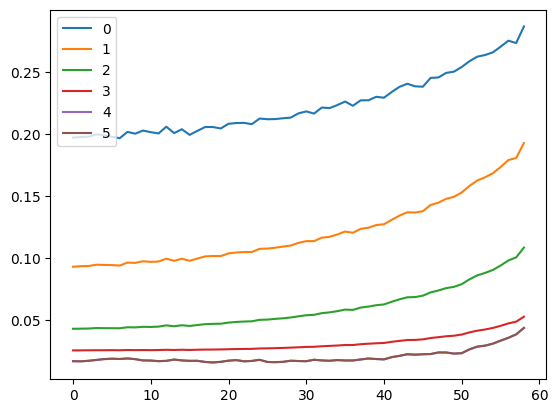

In [ ]:
for h in hcb:
    plt.plot(h.stats[1])
plt.legend(range(6));

## Histogram

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    hook.stats[0].append(outp.mean().item())
    hook.stats[1].append(outp.std().item())
    hook.stats[2].append(outp.abs().histc(40, 0, 10))

In [ ]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
hcb = HooksCB(append_stats, mod_filter=fc.risinstance([nn.ReLU, nn.Flatten]))

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

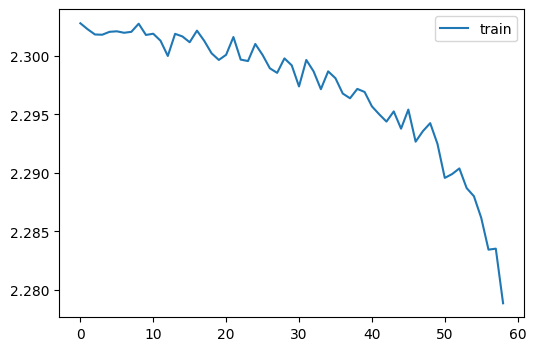

<minai.learner.TrainLearner>

In [ ]:
fit(model, xtra_cbs=[hcb])

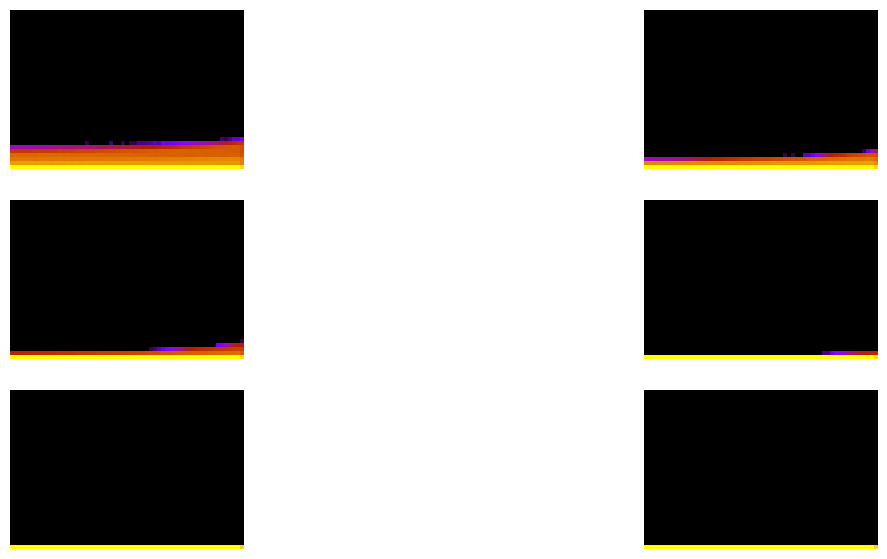

In [ ]:
fig, axs = subplots(3, 2, figsize=(15, 7))
for ax, h in zip(axs.flatten(), hcb):
    show_image(get_hist(h), ax, origin='lower', cmap='gnuplot')

In [ ]:
hcb = HooksCB(append_stats, mod_filter=fc.risinstance([nn.Conv2d]))

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

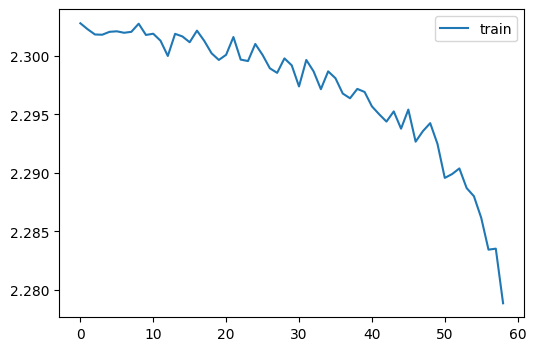

<minai.learner.TrainLearner>

In [ ]:
fit(model, xtra_cbs=[hcb])

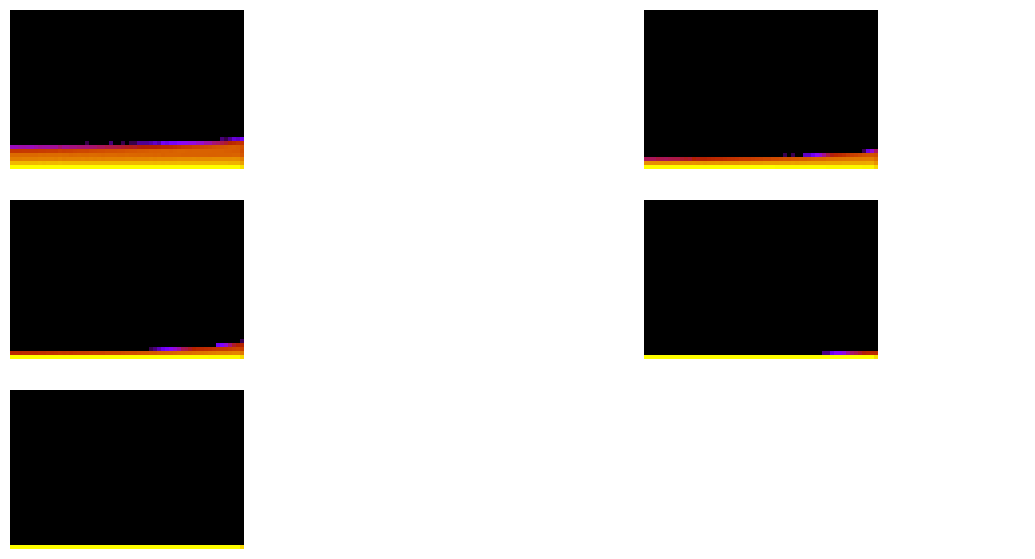

In [ ]:
fig, axs = get_grid(5, nrows=3, figsize=(15, 7))
for ax, h in zip(axs.flatten(), hcb):
    show_image(get_hist(h), ax, origin='lower', cmap='gnuplot')

In [ ]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

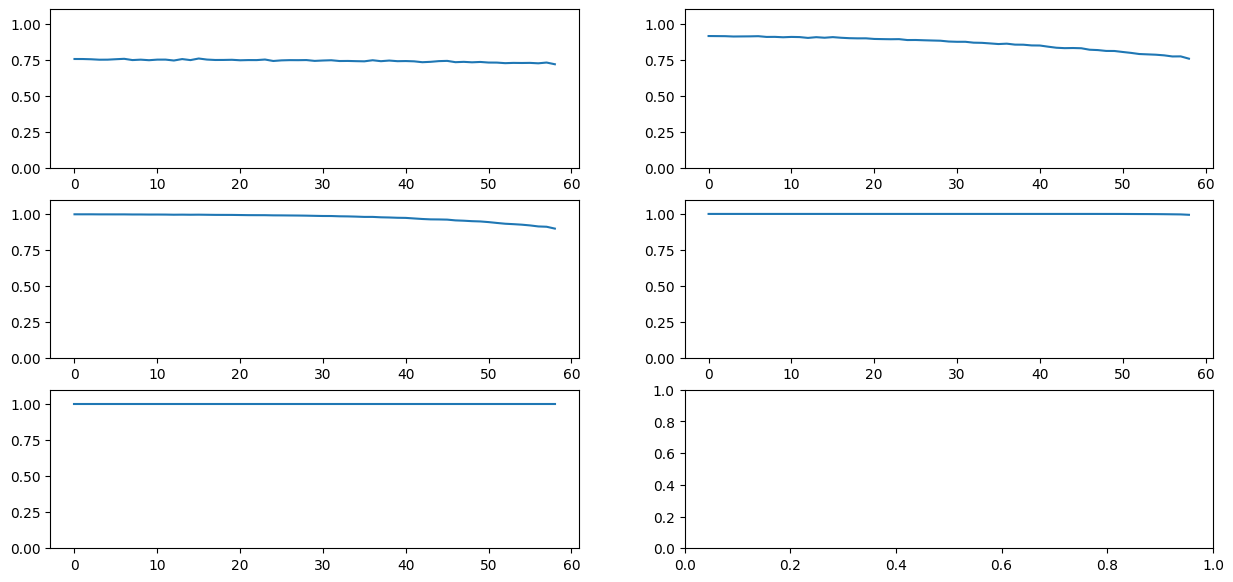

In [ ]:
fig, axs = subplots(3, 2, figsize=(15, 7))
for ax, h in zip(axs.flatten(), hcb):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1.1)

## Activation Stats

In [ ]:
class ActivationStats(HooksCB):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter=mod_filter)
    
    def color_dim(self, figsize=(15, 7)):
        fig, axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flatten(), self):
            show_image(get_hist(h), ax, origin='lower', cmap='gnuplot')
    
    def plot_min(self, figsize=(15, 7)):
        fig, axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1.1)
    
    def plot_stats(self, figsize=(15, 7)):
        fig, axs = subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0, 1:
                axs[i].plot(h.stats[i])
        plt.legend(fc.L.range(len(self)));

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

In [ ]:
set_seed(1)
model = nn.Sequential(*get_cnn())

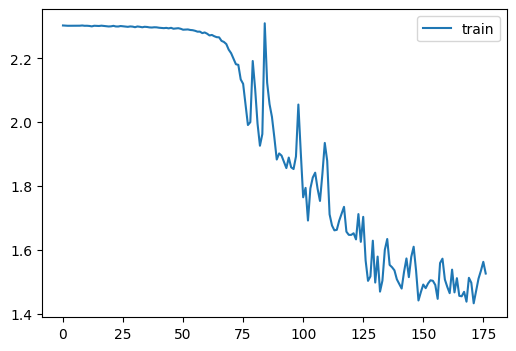

<minai.learner.TrainLearner>

In [ ]:
fit(model, epochs=3, xtra_cbs=[astats])

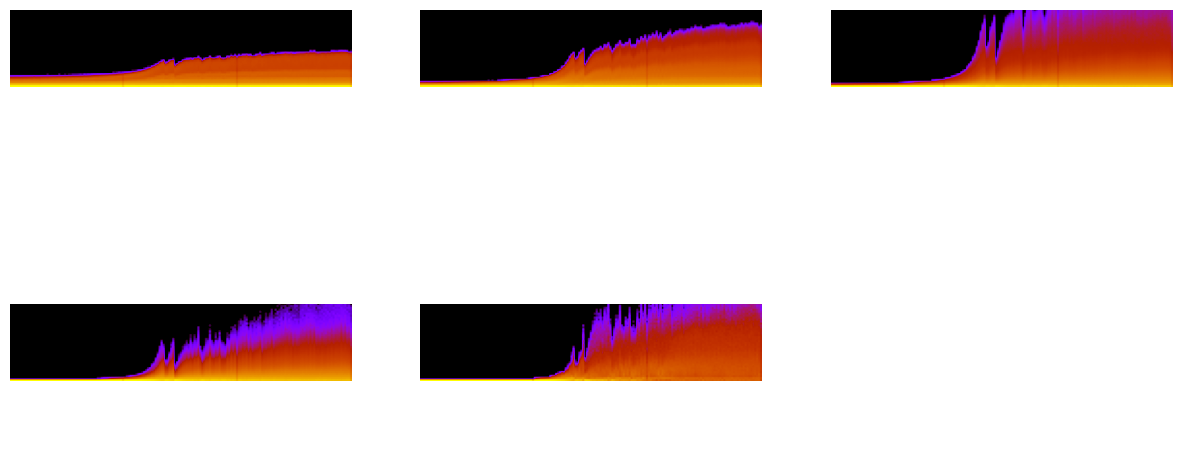

In [ ]:
astats.color_dim()

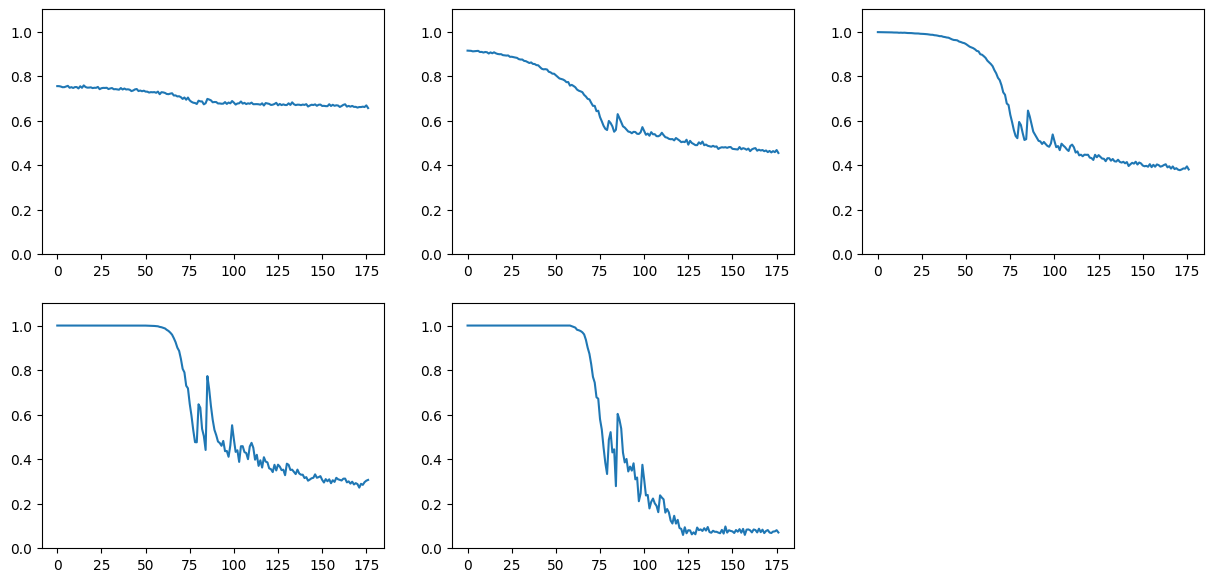

In [ ]:
astats.plot_min()

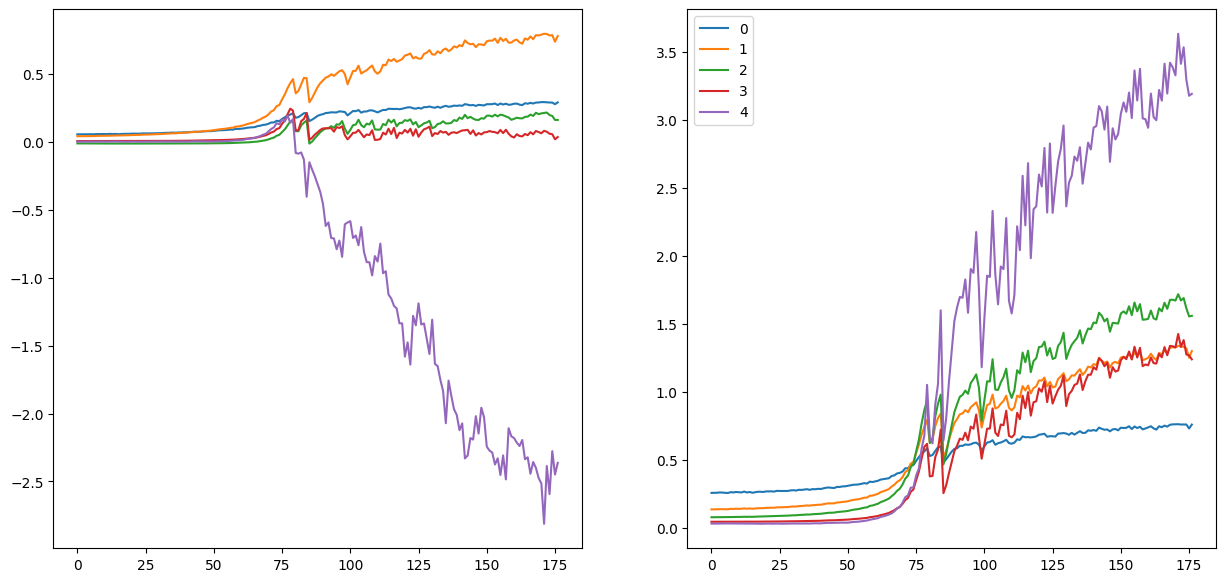

In [ ]:
astats.plot_stats()